# TensorFlow 튜토리얼 #03-C
# Keras API

원저자 [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ) / 번역 곽병권

## 개요

튜토리얼 # 02에서는 TensorFlow에서 컨볼루션 신경망을 구현하는 방법을 보여주었습니다. 우리는 네트워크에서 레이어를 만들기 위한 몇 가지 도움 기능을 만들었습니다. 복잡한 모델을 훨씬 쉽게 구현하고 오류 위험을 낮추기 때문에 우수한 고급 API를 갖추는 것이 중요합니다.

TensorFlow에는 PrettyTensor (Tutorial # 03), Layers API (Tutorial # 03-B) 및 기타 여러 빌더 API가 있습니다. 그러나 그들은 실제로 끝나지 않았으며 이제는 개발자들에 의해 다소 포기 된 것 처럼 보입니다.

이 튜토리얼은 Keras API에 대해 다루고 있습니다. Keras API는 이미 매우 훌륭한 문서로 개발되었으며, 개발이 계속됩니다. Keras는 향후 TensorFlow의 표준 API가 될 가능성이 높으므로 다른 API 대신 Keras를 사용하는 것이 좋습니다.

Keras의 저자는 독자가 읽어야하는 API 디자인 철학을 [블로그 - 게시물] (https://blog.keras.io/user-experience-design-for-apis.html) 작성했습니다.

## 흐름도

다음 차트는 아래에 구현 된 컨볼루션 신경망 (Convolutional Neural Network)의 데이터 흐름을 대략적으로 보여줍니다. 컨볼루션에 대한 자세한 설명은 튜토리얼 #02를 참조하십시오.

두 개의 컨볼루션 레이어가 있으며, 각각 최대 풀링을 사용한 다운 샘플링이 배치됩니다. (이 순서도에는 표시되지 않음). 그런 다음 softmax 분류로 끝나는 완전히 연결된 두 개의 레이어가 있습니다.

![Flowchart](images/02_network_flowchart.png)

## Imports

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import keras

Keras에서 여러 항목을 가져와야합니다.

In [75]:
# from tf.keras.models import Sequential  # This does not work!
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten

이것은 Python 3.6 (Anaconda) 및 TensorFlow 버전을 사용하여 개발되었습니다.

In [76]:
tf.__version__

'1.3.0'

In [77]:
keras.__version__

'2.1.2'

## Load Data

MNIST 데이터 세트는 약 12MB이며 주어진 경로에 위치하지 않으면 자동으로 다운로드 됩니다.

In [78]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터 세트는 현재 로드 되었으며 70.000개의 이미지 및 관련 라벨 (즉, 이미지의 분류)로 구성됩니다. 데이터 집합은 3개의 상호 배타적인 하위 집합으로 나뉩니다. 이 튜토리얼에서는 훈련 및 테스트 세트 만 사용합니다.

In [79]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


클래스 레이블은 One-Hot로 인코딩 됩니다. 즉, 각 레이블은 하나의 요소를 제외하고 모두 0 인 요소가 포함 된 10개의 벡터입니다. 이 요소의 색인은 클래스 번호, 즉 연관된 이미지에 표시된 숫자입니다. 테스트 집합에 대한 클래스 수를 정수로 필요로 하므로 지금 계산합니다.

In [80]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

데이터 차원은 아래 소스 코드의 여러 위치에서 사용됩니다. 그것들은 한 번 정의되어 있으므로 아래의 소스 코드에서 숫자 대신 이러한 변수를 사용할 수 있습니다.

In [81]:
# MNIST 데이터는 이미지의 한 변이 28 픽셀입니다.
img_size = 28

# 이미지는 각 변의 크기를 곱한 수의 일차원 배열로 표현이 됩니다.
img_size_flat = img_size * img_size

# 높이와 넓이로 구성된 튜플은 이미지를 재구성하기 위해서 필요합니다.
# 이 값은 이미지를 그리기 위해서 사용합니다.
img_shape = (img_size, img_size)

# 높이, 넓이, 그리고 깊이로 구성된 튜플은 배열을 재구성하기 위해서 사용합니다.
# Keras에서 재구성을 위해서 사용합니다.
img_shape_full = (img_size, img_size, 1)

# 이미지의 컬러 채널의 수: 1 그레이 스케일 이미지의 경우 1
num_channels = 1

# 클래스의 수, 클래스는 0~9까지의 숫자를 의미합니다.
num_classes = 10

### 이미지를 그리는 도움 함수

3x3그리드에 9개의 이미지를 플롯하고 각 이미지 아래에 참 및 예측 클래스를 쓰는 데 사용되는 함수입니다.

In [82]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 일부의 이미지를 그려서 데이터가 정확한지 확인해 봅니다.

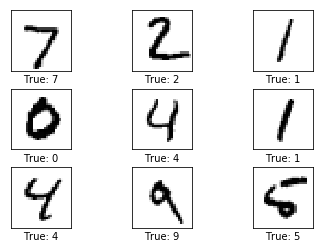

In [83]:
# 테스트 세트의 앞 부부분의 이미지를 가져옵니다.
images = data.test.images[0:9]

# 해당 이미지의 참 분류 값을 가져옵니다.
cls_true = data.test.cls[0:9]

# 위에서 선언한 도움 함수를 이용하여 이미지와 참 값을 그려봅니다.
plot_images(images=images, cls_true=cls_true)

### 분류 오류 이미지의 예를 표시하는 도움 함수

잘못 분류 된 테스트 세트의 이미지 예제를 출력하는 함수

In [84]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.test.cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## PrettyTensor API

이것은 PrettyTensor API를 사용하여 Tutorial #03에서 컨볼루션 신경망이 구현 된 방법입니다. 아래의 Keras 구현과 쉽게 비교할 수 있습니다.

In [85]:
if False:
    x_pretty = pt.wrap(x_image)

    with pt.defaults_scope(activation_fn=tf.nn.relu):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=16, name='layer_conv1').\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=36, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=128, name='layer_fc1').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

## Sequential Model

Keras API에는 신경망을 구성하는 두 가지 모드가 있습니다. 가장 간단한 방법은 레이어를 순차적으로 추가하는 Sequential Model입니다.

In [86]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax'))

### Model Compilation

여기까지 신경망 구성은 완성했습니다. 이제 손실 함수, 옵티 마이저 및 성능 메트릭을 추가하여 완성해야합니다. 이것은 Keras에서 모델 "컴파일"이라고합니다.

우리는 문자열을 사용하여 옵티 마이저를 정의 할 수 있습니다. 또는 매개 변수를 더 제어하려면 객체를 인스턴스화 해야 합니다. 예를 들어 학습률을 설정할 수 있습니다.

In [87]:
from keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

가능한 10 개의 클래스를 가진 MNIST 분류 문제의 경우, `categorical_crossentropy`라고 불리는 손실 함수를 사용 할 필요가 있습니다. 우리가 관심을 갖는 성능 측정 기준은 분류 정확도입니다.

In [88]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 학습 (Traning)

모델이 손실 함수 및 최적화 프로그램으로 완전히 정의되었으므로 이제는 이를 학습 할 수 있습니다. 이 함수는 numpy-arrays를 입력으로 받고 주어진 batch-size를 사용하여 주어진 수의 훈련 에포크를 수행합니다. 에포크란 전체 훈련 세트를 완전히 한번 훈련을 마치는 것을 말 합니다. 따라서 10개 에포크의 경우 전체 훈련 세트에서 무작위로 10번 반복합니다.

In [89]:
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 40s 735us/step - loss: 0.2125 - acc: 0.9364


### 평가

모델이 학습되었으므로 테스트 세트에서 성능을 측정 할 수 있습니다. numpy 배열을 입력으로 사용합니다.

In [90]:
result = model.evaluate(x=data.test.images,
                        y=data.test.labels)

10000/10000 [==============================] - 3s 299us/step


테스트 세트의 모든 성능 요소를 출력 할 수 있습니다.

In [91]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.070045869498
acc 0.9774


또는 분류 정확도를 출력 할 수도 있습니다.

In [92]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 97.74%


### 예측

또한 새로운 이미지의 분류를 예측할 수 있습니다. 테스트 세트의 일부 이미지만 사용 하겠지만 자신이 가지고 있는 이미지를 수십 개의 배열에 로드하여 대신 사용할 수도 있습니다.

In [93]:
images = data.test.images[0:9]

아래는 이미지들을 위한 클래스 번호입니다. 이것은 이미지를 그릴 때만 사용됩니다.

In [94]:
cls_true = data.test.cls[0:9]

예측 클래스를 One-Hot 인코딩 배열로 가져옵니다.

In [95]:
y_pred = model.predict(x=images)

예상 클래스를 정수로 가져옵니다.

In [96]:
cls_pred = np.argmax(y_pred,axis=1)

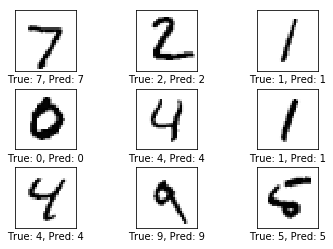

In [97]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### 잘못 분류된 이미지 사례

우리는 잘못 분류 된 이미지의 예제를 테스트 세트에서 플롯 할 수 있습니다.

먼저, 테스트 세트의 모든 이미지에 대한 예상 클래스를 얻습니다.

In [98]:
y_pred = model.predict(x=data.test.images)

그런 다음 예측 된 클래스를 One-Hot로 인코딩 된 배열에서 정수로 변환합니다.

In [99]:
cls_pred = np.argmax(y_pred,axis=1)

잘못 분류 된 이미지를 그려줍니다.

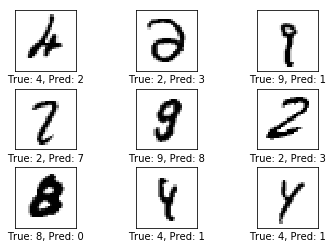

In [100]:
plot_example_errors(cls_pred)

## Functional Model

Keras API 함수 모델을 사용하면 더 복잡한 네트워크를 구성 할 수도 있습니다. 처음에는 Keras API를 호출 할 때마다 호출 할 수 있는 인스턴스를 만들고 반환하기 때문에 처음에는 약간 혼란스러워 보일 수 있습니다. 함수인지 객체인지는 분명하지 않지만 함수 인 것처럼 호출 할 수 있습니다. 이를 통해 Sequential Model이 허용하는 것보다 더 복잡한 연산 그래프를 작성할 수 있습니다.

In [101]:
# Create an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
inputs = Input(shape=(img_size_flat,))

# Variable used for building the Neural Network.
net = inputs

# The input is an image as a flattened array with 784 elements.
# But the convolutional layers expect images with shape (28, 28, 1)
net = Reshape(img_shape_full)(net)

# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# First fully-connected / dense layer with ReLU-activation.
net = Dense(128, activation='relu')(net)

# Last fully-connected / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(num_classes, activation='softmax')(net)

# Output of the Neural Network.
outputs = net

### Model Compilation

위에서 모델의 입력과 출력으로 아키텍처를 정의했습니다. 이제는 Keras 모델을 생성하고 손실 함수 및 최적화 프로그램으로 컴파일해야하므로 교육을받을 준비가되었습니다.

In [102]:
from keras.models import Model

Keras 함수 모델의 새 인스턴스를 만듭니다. 우리는 위에서 사용한 컨볼루션 신경망의 입력과 출력을 사용합니다.

In [103]:
model2 = Model(inputs=inputs, outputs=outputs)

`rmsprop` 옵티 마이저를 사용하고 여러 카테고리에 대해 손실 함수를 사용하여 Keras 모델을 컴파일 합니다. 우리가 관심을 갖고있는 유일한 성능 메트릭은 분류 정확도이지만 여기서 메트릭 목록을 사용할 수 있습니다.

In [104]:
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### 학습 (Traning)

모델은 이제 정의되었고 컴파일되었으므로 위의 Sequential Model에서 사용 된 것과 동일한 `fit ()`함수를 사용하여 훈련 될 수 있습니다. 또한 numpy 배열을 입력으로 사용합니다.

In [105]:
model2.fit(x=data.train.images,
           y=data.train.labels,
           epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 38s 684us/step - loss: 0.2094 - acc: 0.9346


### 평가

모델이 훈련되면 테스트 세트에서 성능을 평가할 수 있습니다. 이것은 순차 모델과 동일한 구문입니다.

In [106]:
result = model2.evaluate(x=data.test.images,
                         y=data.test.labels)

10000/10000 [==============================] - 3s 344us/step


다음의 결과는 손실 값과 모델을 컴파일 할 때 정의한 모든 메트릭을 포함하는 값 목록입니다. '정확도'가 여기서는 'acc'라고 불리는데 이는 일관성이 좀 떨어지기는 합니다.

In [107]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.0458244631268
acc 0.9852


분류 정확도를 백분율로 출력 할 수도 있습니다.

In [108]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 98.52%


### 잘못 분류된 이미지의 사례

우리는 잘못 분류 된 이미지의 예제를 테스트 세트에서 그려볼 수 있습니다.

먼저, 테스트 세트의 모든 이미지에 대한 예상 클래스를 얻습니다.

In [109]:
y_pred = model2.predict(x=data.test.images)

그런 다음 예측 된 클래스 수를 One-Hot로 인코딩 된 배열에서 정수로 변환합니다.

In [110]:
cls_pred = np.argmax(y_pred, axis=1)

잘못 분류 된 이미지를 그립니다.

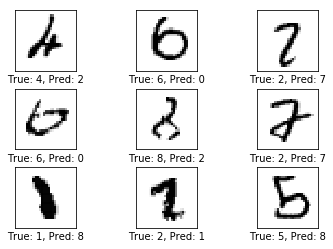

In [111]:
plot_example_errors(cls_pred)

## 모델의 저장과 로드

참고: 이 작업을하려면 `h5py`를 설치해야합니다!

튜토리얼 #04는 기본 TensorFlow 코드를 사용하여 모델의 가중치를 저장하고 복원하는 것에 관한 것입니다. 그것은 너무나 끔찍한 API였습니다! 다행히 Keras는 이것을 매우 쉽게 만듭니다.

다음은 Keras 모델을 저장하려는 파일 경로입니다.

In [112]:
path_model = 'model.keras'

훈련 된 가중치를 가진 Keras 모델을 저장하는 것은 간단한 함수 호출로 가능합니다.

In [113]:
model2.save(path_model)

ImportError: `save_model` requires h5py.

메모리에서 모델을 삭제하여 더 이상 사용되지 않도록 만듭니다.

In [ ]:
del model2

모델 로딩을 위해이 Keras 함수를 가져와야합니다.

In [ ]:
from keras.models import load_model

모델로드는 함수 호출로 끝나야 합니다. 아래와 같이요.

In [ ]:
model3 = load_model(path_model)

그런 다음 모델을 예측을 하는데 다시 사용할 수 있습니다. 테스트 세트의 첫 9 개 이미지와 실제 클래스 번호를 얻습니다.

In [ ]:
images = data.test.images[0:9]

In [ ]:
cls_true = data.test.cls[0:9]

그런 다음 복원 된 모델을 사용하여 해당 이미지의 클래스 번호를 예측합니다.

In [ ]:
y_pred = model3.predict(x=images)

클래스 번호를 정수로 가져옵니다.

In [ ]:
cls_pred = np.argmax(y_pred, axis=1)

참 갑과 예측 된 클래스 번호를 이용하여 이미지를 그립니다.

In [ ]:
plot_images(images=images,
            cls_pred=cls_pred,
            cls_true=cls_true)

## 가중치와 출력 값들의 시각화

### 컨볼루션 가중치를 그리기 위한 도움 함수

In [ ]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 레이어 얻어오기

Keras는 모델의 레이어를 나열하는 간단한 방법을 제공합니다.

In [ ]:
model3.summary()

우리는 우리가 원하는 레이어를 얻기 위해 인덱스를 계산합니다.

입력 레이어의 인덱스는 0입니다.

In [ ]:
layer_input = model3.layers[0]

첫 번째 컨볼루션 계층의 인덱스는 2 입니다.

In [ ]:
layer_conv1 = model3.layers[2]
layer_conv1

두번째 컨볼루션 계층의 인덱스는 4 입니다.

In [ ]:
layer_conv2 = model3.layers[4]

### 컨볼루션 가중치

이제 레이어를 찾을 수 있어서 쉽게 가중치를 얻을 수 있습니다.

In [ ]:
weights_conv1 = layer_conv1.get_weights()[0]

이것은 우리에게 랭크가 4인 텐서를 줍니다.

In [ ]:
weights_conv1.shape

위에서 정의한 도움 함수를 사용하여 가중치를 그려 보겠습니다.

In [ ]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

또한 두 번째 컨볼루션 레이어의 가중치를 가져 와서 그 레이어를 그릴 수 있습니다.

In [ ]:
weights_conv2 = layer_conv2.get_weights()[0]

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

### 컨볼루션 레이어의 출력을 그리기 위한 도움 함수

In [ ]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 입력 이미지

하나의 이미지를 출력하기 위한 도움 함수

In [ ]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

아래 예제는 사용될 테스트 세트의 이미지를 출력합니다.

In [ ]:
image1 = data.test.images[0]
plot_image(image1)

### 컨볼루션 레이어의 출력값을 얻는 방법 - 1

Keras 모델에서 레이어의 출력을 얻는 여러 가지 방법이 있습니다. 이 방법은 Keras 모델의 일부를 함수로 바꾸는 이른바 K-function을 사용합니다.

In [ ]:
from tensorflow.python.keras import backend as K

In [ ]:
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])

그런 다음 입력 이미지로 이 함수를 호출 할 수 있습니다. 함수는 정해진 차원의 배열을 기대하기 때문에 이미지는 두개의 리스트로 싸여 있습니다. 마찬가지로 함수는 우리가 원하는 것보다 한 차원 더 많은 배열을 반환하므로 첫 번째 요소 만 가져옵니다.

In [ ]:
layer_output1 = output_conv1([[image1]])[0]
layer_output1.shape

그런 다음 컨볼루션 계층의 모든 16 개 채널의 출력을 표시 할 수 있습니다.

In [ ]:
plot_conv_output(values=layer_output1)

### 컨볼루션 레이어의 출력값을 얻는 방법 - 2

Keras는 또한 모델 내부에서 레이어의 출력을 얻는 또 다른 방법을 가지고 있습니다. 이것은 원래 모델과 동일한 입력을 사용하는 다른 Functional Model을 생성하지만, 출력은 이제 우리가 관심이있는 컨벌루션 레이어에서 가져옵니다.

In [ ]:
output_conv2 = Model(inputs=layer_input.input,
                     outputs=layer_conv2.output)

이것은 전형적인 Keras 함수를 호출 할 수있는 새로운 모델 객체를 생성합니다. 컨볼루션 레이어의 출력을 얻으려면 입력 이미지와 함께 `predict()`함수를 호출하십시오.

In [ ]:
layer_output2 = output_conv2.predict(np.array([image1]))
layer_output2.shape

그런 다음 36 개 채널 모두에 대해 이미지를 표시 할 수 있습니다.

In [ ]:
plot_conv_output(values=layer_output2)

## 결론

이 튜토리얼은 TensorFlow에서 컨볼루션 신경망을 쉽게 구축하기 위해 *Keras API*를 사용하는 방법을 보여줍니다. Keras는 TensorFlow를위한 가장 완벽하고 설계된 최고의 API입니다.

이 자습서에서는 Keras를 사용하여 모델을 저장하고 로드하는 방법과 컨볼루션 레이어의 가중치 및 출력을 가져 오는 방법도 보여줍니다.

Keras가 TensorFlow의 표준 API가 될 가능성이 높습니다. 그 이유는 이미 매우 좋으며 끊임없이 개선되고 있다는 단순한 이유 때문입니다. Keras를 사용하는 것이 권장합니다.

## 연습 문제

TensorFlow 사용 기술을 향상 시키는데 도움이 될 수 있는 몇 가지 제안 사항입니다. TensorFlow를 제대로 사용하는 방법을 배우려면 실습 경험을 얻는 것이 중요합니다.

변경하기 전에이 노트북을 백업 해 두기를 추천합니다.

* 더 많은 에포크를 학습하십시오. 분류 정확도가 향상됩니까?
* 일부 레이어의 활성화 함수를 시그모이드로 변경합니다.
* 모든 레이어에 대해 활성화 함수를 변경하는 간단한 방법을 찾아보세요.
* 컨볼루션 대신에 max-pooling layer의 출력을 화면에 출력해 보세요.
* 컨벌루션 레이어에서 2x2 max-pooling 레이어를 stride = 2로 바꿉니다. 분류 정확도에 차이가 있습니까? 당신이 그것을 계속해서 또 다시 최적화하면 어떨까요? 차이는 랜덤하게 나타납니다. 그래서 실제로 차이가 있다면 그 차이를 어떻게 측정합니까? 컨볼루션 레이어에서 max-pooling과 stride의 장점과 단점은 무엇입니까?
* 레이어의 매개 변수를 변경합니다 (예: 커널, 깊이, 크기 등 시간 사용 및 분류 정확도의 차이점은 무엇입니까?
* 컨볼루션 네트워크와 완전히 연결된 레이어를 각각 추가해보고 제거해 보세요.
* 여전히 성능이 잘 나오는 가장 단순한 네트워크는 무엇입니까?
* 기능 모델을 변경하여 완전 연결 레이어로 들어가기 전에 기존의 컨볼루션 네트워크와 병렬로 연결되는 다른 컨볼루션 레이어를 만들어 보세요.
* 기능 모델을 변경하여 예측 클래스를 One-Hot 인코딩 배열과 정수로 출력하도록 변경하여 나중에 numpy.argmax()를 사용할 필요가 없도록 만들어 봅니다.
* 이 소스 코드를 너무 많이 보지 않고 직접 프로그램을 다시 제작하십시오.
* 프로그램이 어떻게 작동하는지 동료에게 설명하십시오.

## 라이센스 (MIT)

저작권 (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

사용, 복사, 수정, 병합 할 수있는 권한을 포함하되 이에 국한되지 않고 소프트웨어를 취급하기 위해이 소프트웨어 및 관련 문서 파일 (이하 "소프트웨어")의 사본을 얻는 모든 사람에게 사용 권한이 무료로 부여됩니다 다음 조건에 따라 소프트웨어의 사본을 게시, 배포, 재 라이센스 또는 판매 할 수 있고 소프트웨어를 제공받는 사람에게 허용 할 수 있습니다.

위의 저작권 고지 및 이 허가 고지는 소프트웨어의 모든 사본 또는 상당 부분에 포함되어야합니다.

소프트웨어는 상품성, 특정 목적에의 적합성 및 비 침해에 대한 보증을 포함하여 (단, 이에 한하지 않음) 묵시적이든 명시적이든 어떠한 종류의 보증없이 "있는 그대로"제공됩니다. 제작자 또는 저작권 보유자는 소프트웨어 또는 사용과 관련하여 발생했거나 또는 기타 행위로 인해 발생한 청구, 기타 책임에 대해 어떠한 경우에도 책임을지지 않습니다.